<a href="https://colab.research.google.com/github/AeMcRa/Datascience-things/blob/main/Copy_of_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

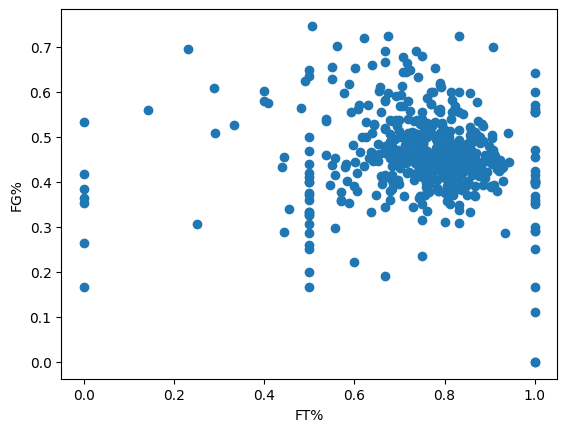

In [ ]:
#make scatter plot of FT% and FG% for NBA players form the 23/24 season
plt.scatter(basketball['FT%'] , basketball['FG%'],)

#label axes
plt.xlabel("FT%")
plt.ylabel("FG%")

looks relatively similar to charts we've seen for this data in the past, but this time there is more data points and also there are strange vertical lines of data around 1, 0 and 0.5 FT%

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

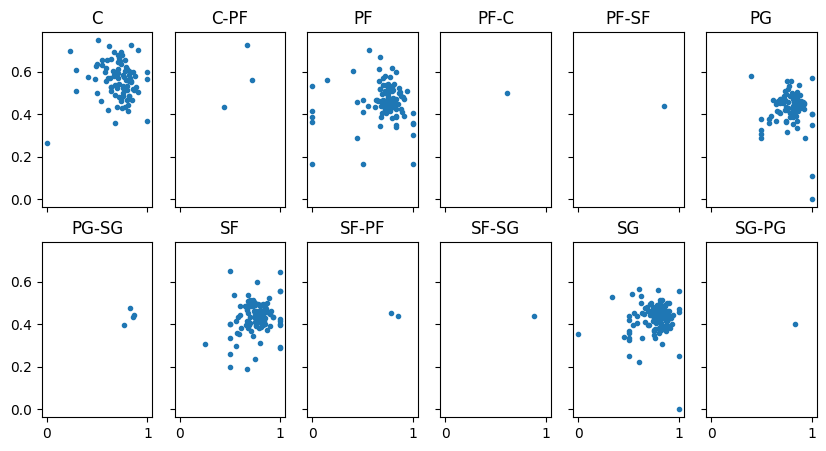

In [ ]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

Generally the data looks relatively similar,apart from PF and C which look more concentrated. This concentration decreases the negative trendlines. The presence of the weird lines seems to be widening the range depicted

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

due to the graphs here, due to the weird lines is much more bloblike and disparate and doesn't have a very strong trend in any direction. As such, there is no strong linear relation.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [ ]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [ ]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'weight')

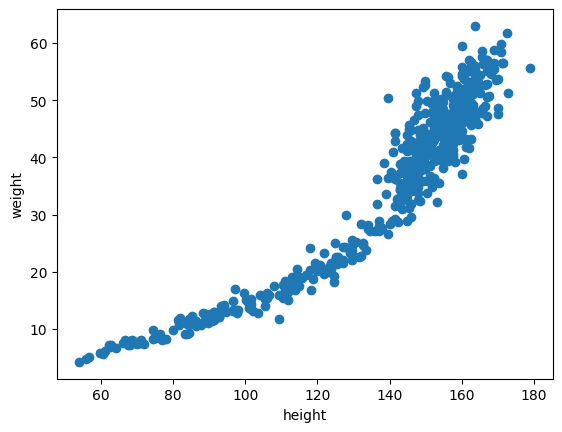

In [ ]:
plt.scatter(howell['height'] , howell['weight'],)

#label axes
plt.xlabel("height")
plt.ylabel("weight")

woaw it linear

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
with pm.Model() as model_lh:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.HalfNormal("α", sigma=10)
    β = pm.Gamma("β", mu = .3, sigma=0.2)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_lh = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0, 0.5, 'weight')

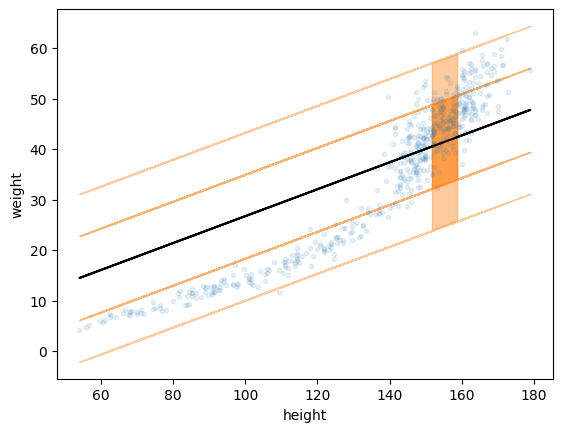

In [ ]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_lh = az.extract(idata_lh)

μ_m = posterior_lh["μ"].mean("sample").values
σ_m = posterior_lh["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [ ]:
pm.sample_posterior_predictive(
    idata_lh, model = model_lh, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

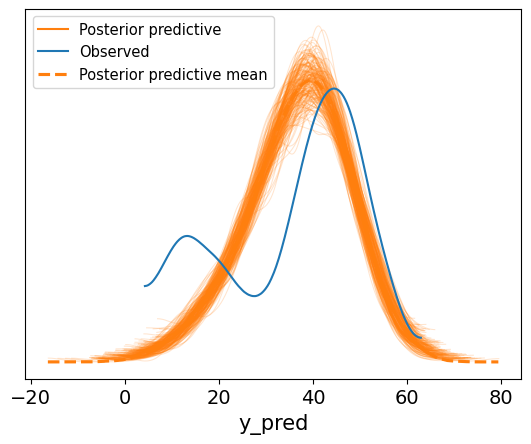

In [ ]:
az.plot_ppc(idata_lh, num_pp_samples=200, colors=["C1", "C0", "C1"])

the fit is poor at best, and fails to capture the nuance of the observed data. The posterior predictive is a simpleton attempt to model the observed data, but simply fails to embody it's bimodal nature.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [ ]:
with pm.Model() as model_sqrh:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.HalfNormal("α", sigma=10)
    β = pm.Gamma("β", mu = .3, sigma=0.2)

    α_two = pm.Gamma("α_two",mu = 1, sigma= 0.5)
    β_two = pm.Gamma("β_two",mu = 1, sigma= 0.5)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqr(howell.height))
    σ = pm.Deterministic("σ", α_two + β_two * pm.math.sqr(howell.height))

    #prior for standard deviation
    #σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_sqrh = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0, 0.5, 'weight')

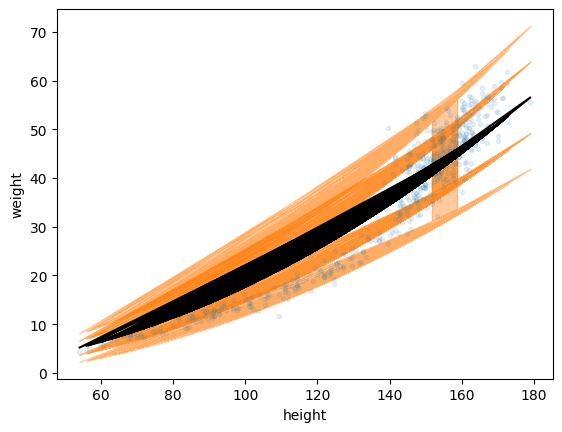

In [ ]:

_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_sqrh = az.extract(idata_sqrh)

μ_m = posterior_sqrh["μ"].mean("sample").values
σ_m = posterior_sqrh["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [ ]:
pm.sample_posterior_predictive(
    idata_sqrh, model = model_sqrh, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

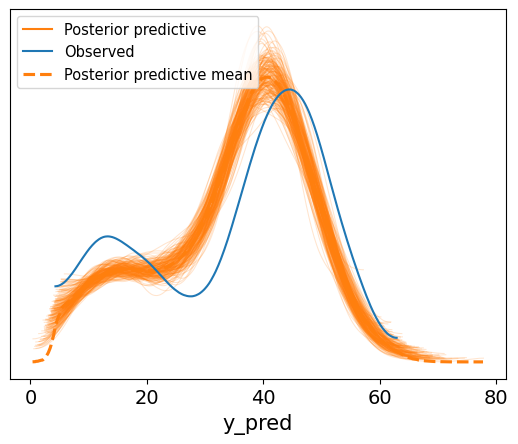

In [ ]:
az.plot_ppc(idata_sqrh, num_pp_samples=200, colors=["C1", "C0", "C1"])

I think this is a lot better. Our model more accurately describes the bimodal nature of our data, and aside from a small offset is relativly representative